# Transfer Learning with Time Series Models

On this notebook I will show how to use transfer learning with time series models.
Transfer learning is a technique where a model trained on one task is re-purposed on a second related task.
It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision tasks.
For the pre-trained model we are going to use the Chronos model and compare it with the TiDE and TSMixer models that we are training from scratch.

The dataset used is the Walmart Sales Forecasting dataset from the Kaggle competition [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data).


The model with the best potential for the following prediction problem is the Chronos model. But hopefully with the combinations of the models we can achieve better results. Let's see how it goes.

# Load Libraries and set global variables

In [1]:
try:
    import darts
except ImportError:
    %pip install -r requirements.txt

In [ ]:
%load_ext autoreload
%autoreload 2
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TiDEModel, TSMixerModel
from chronos import ChronosPipeline
from darts import TimeSeries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import random
import torch
import utils

TIME_COL = "Date"
TARGET = "Weekly_Sales"
RES_TARGET = "residuals"
STATIC_COV = ["Store", "Dept", "Type", "Size", "unique_id"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"

SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

FORECAST_HORIZON = 10  # number of weeks to forecast
TOP_STORES = 500  # number of top stores to forecast

CHRONOS_ARCHITECTURE = ("amazon/chronos-t5-tiny", "cpu")
# CHRONOS_ARCHITECTURE = ("amazon/chronos-t5-tiny","cuda")
# CHRONOS_ARCHITECTURE = ("amazon/chronos-t5-large","cuda")

# Load and Pre-process dataset

In [3]:
def get_df():
    # load data and exogenous features
    df = pd.read_csv('data/train.csv')
    store_info = pd.read_csv('data/stores.csv')
    exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

    # join all data frames
    df = pd.merge(df, store_info, on=['Store'], how='left')
    df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

    # create unique id
    df["unique_id"] = df['Store'].astype(str) + '-' + df['Dept'].astype(str)

    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df.loc[:, TIME_COL] = pd.to_datetime(df[TIME_COL])

    df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET])
    df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = df[
        ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)  # fill missing values with nan
    df["IsHoliday"] = df["IsHoliday"] * 1  # convert boolean into binary
    df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                          np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
                                   "medium"))  # make size a categorical variable

    top_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET,
                                                                                          ascending=False).head(
        TOP_STORES)
    return df[df['unique_id'].isin(top_stores['unique_id'])]

In [4]:
df = get_df()

top3_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(
    3)
top10_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET,
                                                                                        ascending=False).head(10)

# Training the models up to the start of the window and forecasting 10 weeks ahead, for each window

In [5]:
window1_start = pd.to_datetime('2012-01-20')
window1 = (window1_start, window1_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test1 = df[(df[TIME_COL] <= window1[1])]

window2_start = pd.to_datetime('2012-03-16')
window2 = (window2_start, window2_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test2 = df[(df[TIME_COL] <= window2[1])]

window3_start = pd.to_datetime('2012-05-25')
window3 = (window3_start, window3_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test3 = df[(df[TIME_COL] <= window3[1])]

window4_start = pd.to_datetime('2012-08-03')
window4 = (window4_start, window4_start + pd.Timedelta(weeks=FORECAST_HORIZON))
test4 = df[(df[TIME_COL] <= window4[1])]

tests = [test1, test2, test3, test4]
windows = [window1, window2, window3, window4]

# TSMixer

In [6]:
TSMixer_params = {
    "input_chunk_length": 12,
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 16,
    "ff_size": 4,
    "num_blocks": 1,
    "activation": "ELU",
    "dropout": 0.3,
    "normalize_before": True,
    "batch_size": 32,
    "n_epochs": 10,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 0.001},
    "use_reversible_instance_norm": False,
}

To save time I will not run the TSMixer model again. I will just load the forecasts that I have already saved with this code for all the windows:

<br>

```python
for window in windows:
    train = df[(df["Date"] <= window[0])]
    test = df[(df["Date"] > window[0]) & (df["Date"] <= window[1])]
    df = df[(df[TIME_COL] <= window[1])]
    
    train_darts = TimeSeries.from_group_dataframe(
        df=train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)
    
    dynamic_covariates = utils.create_dynamic_covariates(train_darts,df,FORECAST_HORIZON)
    
    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
    
    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(train_darts)
    
    tsmixer = TSMixerModel(**TSMixer_params)
    tsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
    tsmixer_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
    tsmixer_forecast.to_csv('data/tsmixer_forecast' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
    window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)
```

In [7]:
tsmixer_forecast_window1 = pd.read_csv('data/tsmixer_forecast_2012-01-20_2012-03-30.csv')
tsmixer_forecast_window1['Date'] = pd.to_datetime(tsmixer_forecast_window1['Date'])

tsmixer_forecast_window2 = pd.read_csv('data/tsmixer_forecast_2012-03-16_2012-05-25.csv')
tsmixer_forecast_window2['Date'] = pd.to_datetime(tsmixer_forecast_window2['Date'])

tsmixer_forecast_window3 = pd.read_csv('data/tsmixer_forecast_2012-05-25_2012-08-03.csv')
tsmixer_forecast_window3['Date'] = pd.to_datetime(tsmixer_forecast_window3['Date'])

tsmixer_forecast_window4 = pd.read_csv('data/tsmixer_forecast_2012-08-03_2012-10-12.csv')
tsmixer_forecast_window4['Date'] = pd.to_datetime(tsmixer_forecast_window4['Date'])

tsmixer_forecasts = [tsmixer_forecast_window1, tsmixer_forecast_window2, tsmixer_forecast_window3,
                    tsmixer_forecast_window4]

# TiDE

In [8]:
TiDE_params= {
    'input_chunk_length': 12,
     'output_chunk_length': FORECAST_HORIZON,
     'num_encoder_layers': 4,
     'num_decoder_layers': 8,
     'decoder_output_dim': 8,
     'hidden_size': 8,
     'temporal_width_past': 16,
     'temporal_width_future': 8,
     'temporal_decoder_hidden': 128,
     'dropout': 0.2,
     'batch_size': 16,
     'n_epochs': 20,
     'likelihood': QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
     'random_state': 42,
     'use_static_covariates': True,
     'optimizer_kwargs': {'lr': 0.001},
     'use_reversible_instance_norm': False,
     
}

To save time I will not run the TiDE model again. I will just load the forecasts that I have already saved with this code for all the windows:

<br>

```python
for window in windows:
    train = df[(df["Date"] <= window[0])]
    test = df[(df["Date"] > window[0]) & (df["Date"] <= window[1])]
    df = df[(df[TIME_COL] <= window[1])]
    
    train_darts = TimeSeries.from_group_dataframe(
        df=train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)
    
    dynamic_covariates = utils.create_dynamic_covariates(train_darts,df,FORECAST_HORIZON)
    
    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
    
    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(train_darts)
    
    tide = TiDEModel(**TiDE_params)
    tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
    tide_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
    tide_forecast.to_csv('data/tide_forecast' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
    window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)
```

In [9]:
tide_forecast_window1 = pd.read_csv('data/tide_forecast_2012-01-20_2012-03-30.csv')
tide_forecast_window1['Date'] = pd.to_datetime(tide_forecast_window1['Date'])

tide_forecast_window2 = pd.read_csv('data/tide_forecast_2012-03-16_2012-05-25.csv')
tide_forecast_window2['Date'] = pd.to_datetime(tide_forecast_window2['Date'])

tide_forecast_window3 = pd.read_csv('data/tide_forecast_2012-05-25_2012-08-03.csv')
tide_forecast_window3['Date'] = pd.to_datetime(tide_forecast_window3['Date'])

tide_forecast_window4 = pd.read_csv('data/tide_forecast_2012-08-03_2012-10-12.csv')
tide_forecast_window4['Date'] = pd.to_datetime(tide_forecast_window4['Date'])

tide_forecasts = [tide_forecast_window1, tide_forecast_window2, tide_forecast_window3, tide_forecast_window4]

# Chronos

To save time I will not run the Chronos model again. I will just load the forecasts that I have already saved with this code for all the windows:

<br>

```python

for window in windows:
    train = df[(df["Date"] <= window[0])]
    test = df[(df["Date"] > window[0]) & (df["Date"] <= window[1])]
    df = df[(df[TIME_COL] <= window[1])]
    
    train_darts = TimeSeries.from_group_dataframe(
        df=train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)
    
    # Load the Chronos pipeline
    pipeline = ChronosPipeline.from_pretrained(
        CHRONOS_ARCHITECTURE[0],
        device_map=CHRONOS_ARCHITECTURE[1],
        torch_dtype=torch.bfloat16)
    
    forecast = []
    for ts in train_darts:
        # Forecast
        lower, mid, upper = utils.chronos_forecast(pipeline, ts.pd_dataframe().reset_index(), FORECAST_HORIZON)
        forecast.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['unique_id'] == str(int(list(ts.static_covariates_values())[0][0]))+'-'+str(int(list(ts.static_covariates_values())[0][1]))]))
    # Convert list to data frames
    chronos_forecast = pd.concat(forecast)
    chronos_forecast.to_csv('data/chronos_forecast' + str(window[0].date().strftime('%Y-%m-%d')) + '_' + str(
            window[1].date().strftime('%Y-%m-%d')) + '.csv', index=False)
```


In [10]:
chronos_forecast_window1 = pd.read_csv('data/chronos_forecast_2012-01-20_2012-03-30.csv')
chronos_forecast_window1['Date'] = pd.to_datetime(chronos_forecast_window1['Date'])

chronos_forecast_window2 = pd.read_csv('data/chronos_forecast_2012-03-16_2012-05-25.csv')
chronos_forecast_window2['Date'] = pd.to_datetime(chronos_forecast_window2['Date'])

chronos_forecast_window3 = pd.read_csv('data/chronos_forecast_2012-05-25_2012-08-03.csv')
chronos_forecast_window3['Date'] = pd.to_datetime(chronos_forecast_window3['Date'])

chronos_forecast_window4 = pd.read_csv('data/chronos_forecast_2012-08-03_2012-10-12.csv')
chronos_forecast_window4['Date'] = pd.to_datetime(chronos_forecast_window4['Date'])

chronos_forecasts = [chronos_forecast_window1, chronos_forecast_window2, chronos_forecast_window3,
                     chronos_forecast_window4]
all_chronos_forecasts = pd.concat(chronos_forecasts, ignore_index=True)

# Now I will use the forecasts from the Chronos model as dynamic covariates for the TiDE and TSMixer models.

To further refine the predictions, I tuned the TiDE and TSMixer hyperparameters specifically to be ready to receive the chronos forecast as dynamic covariates. 
 

The tuned parameters are saved in the tuned_TiDE_params and tuned_TSMixer_params dictionaries:

In [11]:
tuned_dyncov_TSMixer_params = {
        "input_chunk_length": 4,
        "output_chunk_length": FORECAST_HORIZON,
        "hidden_size": 4,
        "ff_size": 8,
        "num_blocks": 3,
        "activation": "ELU",
        "dropout": 0.15,
        "normalize_before": True,
        "batch_size": 64,
        "n_epochs": 30,
        "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
        "random_state": 42,
        "use_static_covariates": True,
        "optimizer_kwargs": {"lr": 0.0001},
        "use_reversible_instance_norm": True,
    }


tuned_dyncov_TiDE_params = {
        'input_chunk_length': 3,
        'output_chunk_length': FORECAST_HORIZON,
        "num_encoder_layers": 6,
        "num_decoder_layers": 4,
        "decoder_output_dim": 6,
        "hidden_size": 2,
        "temporal_width_past": 2,
        "temporal_width_future": 4,
        "temporal_decoder_hidden": 16,
        "dropout": 0.1,
        "batch_size": 32,
        "n_epochs": 20,
        "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
        "random_state": 42,
        "use_static_covariates": True,
        "optimizer_kwargs": {"lr": 0.001},
        "use_reversible_instance_norm": True,
    }

## TSMixer with chronos forecast as dynamic covariates

In [ ]:
tsmixer_forecasts_w_pred_dyn_cov = []
untuned_tsmixer_forecasts_w_pred_dyn_cov = []

for window, chronos_forecast in zip(windows, chronos_forecasts):
    df = get_df()

    train = df[(df["Date"] <= window[0]) & (df["Date"] >= pd.to_datetime('2011-06-17'))]
    test = df[(df["Date"] > window[0]) & (df["Date"] <= window[1])]
    df = df[(df[TIME_COL] <= window[1]) & (df["Date"] >= pd.to_datetime('2011-06-17'))]

    residuals = pd.read_csv('data/residuals.csv')
    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])
    df = pd.merge(df, residuals[["unique_id", TIME_COL, "residuals"]], on=["unique_id", TIME_COL], how="left")
    df["forecast"] = df[TARGET] - df["residuals"]

    df = pd.merge(df, chronos_forecast[["unique_id", TIME_COL, "forecast"]], on=["unique_id", TIME_COL], how="left")
    df["forecast"] = np.where(df[TIME_COL] > window[0], df["forecast_y"], df["forecast_x"])

    train_darts = TimeSeries.from_group_dataframe(
        df=train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)

    dynamic_covariates = utils.create_dynamic_covariates(train_darts, df, FORECAST_HORIZON, w_pred=True)

    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(train_darts)

    # save the tuned model
    dyncov_tsmixer = TSMixerModel(**tuned_dyncov_TSMixer_params)
    dyncov_tsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(
        dyncov_tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed,
                        num_samples=50))
    tsmixer_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
    tsmixer_forecasts_w_pred_dyn_cov.append(tsmixer_forecast)
    
    # save the untuned model
    dyncov_tsmixer = TSMixerModel(**TSMixer_params)
    dyncov_tsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(
        dyncov_tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed,
                        num_samples=50))
    tsmixer_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
    untuned_tsmixer_forecasts_w_pred_dyn_cov.append(tsmixer_forecast)

## TiDE with chronos forecast as dynamic covariates

In [ ]:
tide_forecasts_w_pred_dyn_cov = []
untuned_tide_forecasts_w_pred_dyn_cov = []

for window, chronos_forecast in zip(windows, chronos_forecasts):
    df = get_df()

    train = df[(df["Date"] <= window[0]) & (df["Date"] >= pd.to_datetime('2011-06-17'))]
    test = df[(df["Date"] > window[0]) & (df["Date"] <= window[1])]
    df = df[(df[TIME_COL] <= window[1]) & (df["Date"] >= pd.to_datetime('2011-06-17'))]

    residuals = pd.read_csv('data/residuals.csv')
    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])
    df = pd.merge(df, residuals[["unique_id", TIME_COL, "residuals"]], on=["unique_id", TIME_COL], how="left")
    df["forecast"] = df[TARGET] - df["residuals"]

    df = pd.merge(df, chronos_forecast[["unique_id", TIME_COL, "forecast"]], on=["unique_id", TIME_COL], how="left")
    df["forecast"] = np.where(df[TIME_COL] > window[0], df["forecast_y"], df["forecast_x"])

    train_darts = TimeSeries.from_group_dataframe(
        df=train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)

    dynamic_covariates = utils.create_dynamic_covariates(train_darts, df, FORECAST_HORIZON, w_pred=True)

    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(train_darts)
    
    # save the tuned model
    dyncov_tide = TiDEModel(**tuned_dyncov_TiDE_params)
    dyncov_tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(
        dyncov_tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed,
                     num_samples=50))
    tide_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
    tide_forecasts_w_pred_dyn_cov.append(tide_forecast)
    
    # save the untuned model
    dyncov_tide = TiDEModel(**TiDE_params)
    dyncov_tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(
        dyncov_tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed,
                     num_samples=50))
    tide_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
    untuned_tid_forecasts_w_pred_dyn_cov.append(tide_forecast)

# Now I will use the Chronos predictions to calculate residuals to train the TSMixer and TiDE models, to then combine the residuals predictions with the original Chronos predictions.

To further refine the predictions, I tuned the TiDE and TSMixer hyperparameters specifically for this task of forecasting chronos residuals. The tuned parameters are saved in the tuned_TiDE_params and tuned_TSMixer_params dictionaries:

In [14]:
tuned_res_TSMixer_params = {
        "input_chunk_length": 4,
        "output_chunk_length": FORECAST_HORIZON,
        "hidden_size": 2,
        "ff_size": 2,
        "num_blocks": 1,
        "activation": "GELU",
        "dropout": 0.1,
        "normalize_before": False,
        "batch_size": 16,
        "n_epochs": 15,
        "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
        "random_state": 42,
        "use_static_covariates": True,
        "optimizer_kwargs": {"lr": 1e-05},
        "use_reversible_instance_norm": True,
    }


tuned_res_TiDE_params = {
        'input_chunk_length': 4,
        'output_chunk_length': FORECAST_HORIZON,
        "num_encoder_layers": 2,
        "num_decoder_layers": 8,
        "decoder_output_dim": 15,
        "hidden_size": 2,
        "temporal_width_past": 2,
        "temporal_width_future": 10,
        "temporal_decoder_hidden": 16,
        "dropout": 0.1,
        "batch_size": 8,
        "n_epochs": 10,
        "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
        "random_state": 42,
        "use_static_covariates": True,
        "optimizer_kwargs": {"lr": 1e-05},
        "use_reversible_instance_norm": True,
    }

## TSMixer residuals predictions + Chronos

In [ ]:
tsmixer_chronos_forecasts = []
untuned_tsmixer_chronos_forecasts = []

for window, chronos_forecast in zip(windows, chronos_forecasts):
    residuals = pd.read_csv('data/residuals.csv')
    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])
    residuals[['Store', 'Dept']] = residuals['unique_id'].str.split('-', expand=True).astype(int)

    residuals_train = residuals[residuals[TIME_COL] <= window[0]]
    residuals = residuals[(residuals[TIME_COL] <= window[1])]

    residuals_darts = TimeSeries.from_group_dataframe(
        df=residuals_train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=RES_TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)

    print(
        f"Weeks for training: {len(residuals_train[TIME_COL].unique())} from {min(residuals_train[TIME_COL]).date()} to {max(residuals_train[TIME_COL]).date()}")

    dynamic_covariates = utils.create_dynamic_covariates(residuals_darts, residuals, FORECAST_HORIZON)

    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(residuals_darts)

    # Save the tuned model
    res_tsmixer = TSMixerModel(**tuned_res_TSMixer_params)
    res_tsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(res_tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed,
                                                          future_covariates=dynamic_covariates_transformed,
                                                          num_samples=50))
    residuals_forecast = utils.transform_predictions_to_pandas(pred, RES_TARGET, residuals_darts, [0.25, 0.5, 0.75],
                                                               convert=False)
    tsmixer_chronos_forecast = utils.combine_predictions(chronos_forecast, residuals_forecast)
    tsmixer_chronos_forecasts.append(tsmixer_chronos_forecast)
    
    # Save the untuned model
    res_tsmixer = TSMixerModel(**TSMixer_params)
    res_tsmixer.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(res_tsmixer.predict(n=FORECAST_HORIZON, series=data_transformed,
                                                          future_covariates=dynamic_covariates_transformed,
                                                          num_samples=50))
    residuals_forecast = utils.transform_predictions_to_pandas(pred, RES_TARGET, residuals_darts, [0.25, 0.5, 0.75],
                                                               convert=False)
    tsmixer_chronos_forecast = utils.combine_predictions(chronos_forecast, residuals_forecast)
    untuned_tsmixer_chronos_forecasts.append(tsmixer_chronos_forecast)

## TiDE residuals predictions + Chronos

In [ ]:
tide_chronos_forecasts = []
untuned_tide_chronos_forecasts = []

for window, chronos_forecast in zip(windows, chronos_forecasts):
    residuals = pd.read_csv('data/residuals.csv')
    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])
    residuals[['Store', 'Dept']] = residuals['unique_id'].str.split('-', expand=True).astype(int)

    residuals_train = residuals[residuals[TIME_COL] <= window[0]]
    residuals = residuals[(residuals[TIME_COL] <= window[1])]

    residuals_darts = TimeSeries.from_group_dataframe(
        df=residuals_train,
        group_cols=STATIC_COV,
        time_col=TIME_COL,
        value_cols=RES_TARGET,
        freq=FREQ,
        fill_missing_dates=True,
        fillna_value=0)

    print(
        f"Weeks for training: {len(residuals_train[TIME_COL].unique())} from {min(residuals_train[TIME_COL]).date()} to {max(residuals_train[TIME_COL]).date()}")

    dynamic_covariates = utils.create_dynamic_covariates(residuals_darts, residuals, FORECAST_HORIZON)

    # scale covariates
    dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

    # scale data and transform static covariates
    data_transformed = PIPELINE.fit_transform(residuals_darts)

    # Save the tuned model
    res_tide = TiDEModel(**tuned_res_TiDE_params)
    res_tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(
        res_tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed,
                         num_samples=50))
    residuals_forecast = utils.transform_predictions_to_pandas(pred, RES_TARGET, residuals_darts, [0.25, 0.5, 0.75],
                                                               convert=False)
    tide_chronos_forecast = utils.combine_predictions(chronos_forecast, residuals_forecast)
    tide_chronos_forecasts.append(tide_chronos_forecast)
    
    
    # Save the untuned model
    res_tide = TiDEModel(**TiDE_params)
    res_tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
    pred = PIPELINE.inverse_transform(
        res_tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed,
                         num_samples=50))
    residuals_forecast = utils.transform_predictions_to_pandas(pred, RES_TARGET, residuals_darts, [0.25, 0.5, 0.75],
                                                               convert=False)
    tide_chronos_forecast = utils.combine_predictions(chronos_forecast, residuals_forecast)
    untuned_tide_chronos_forecasts.append(tide_chronos_forecast)

# Plot Actuals and Forecast

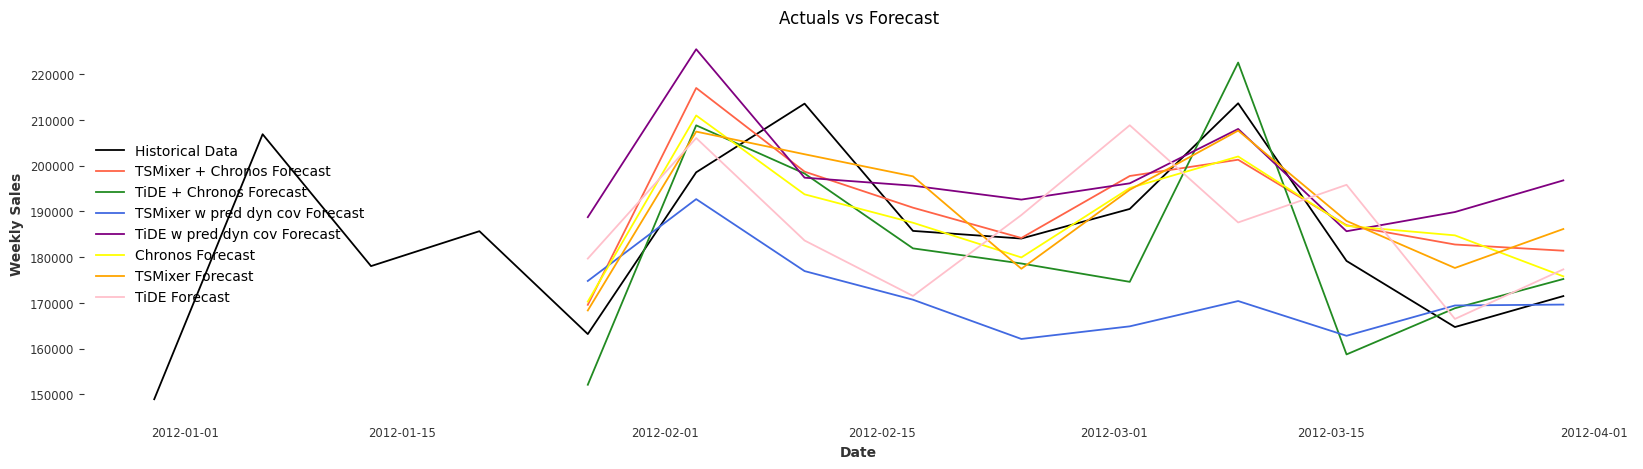

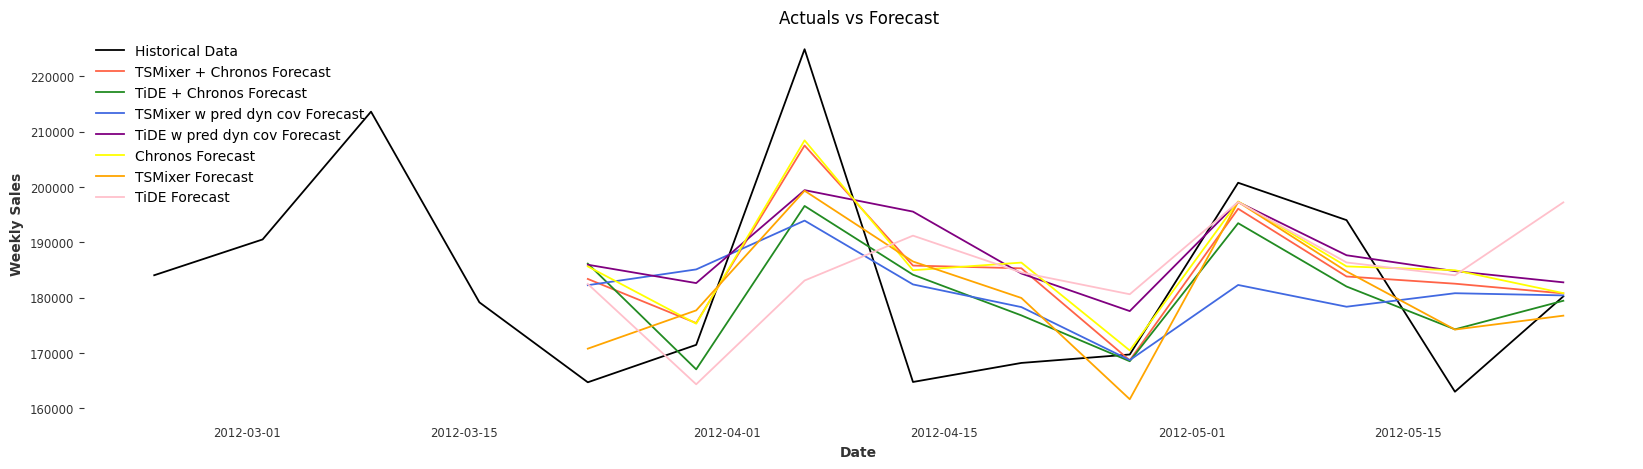

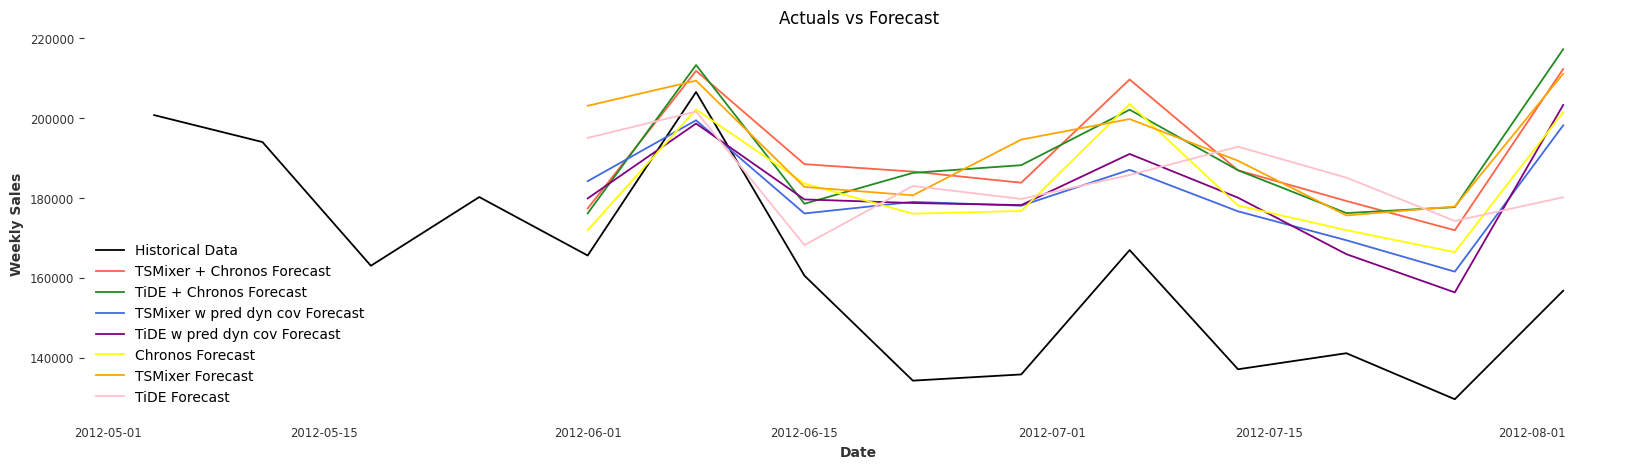

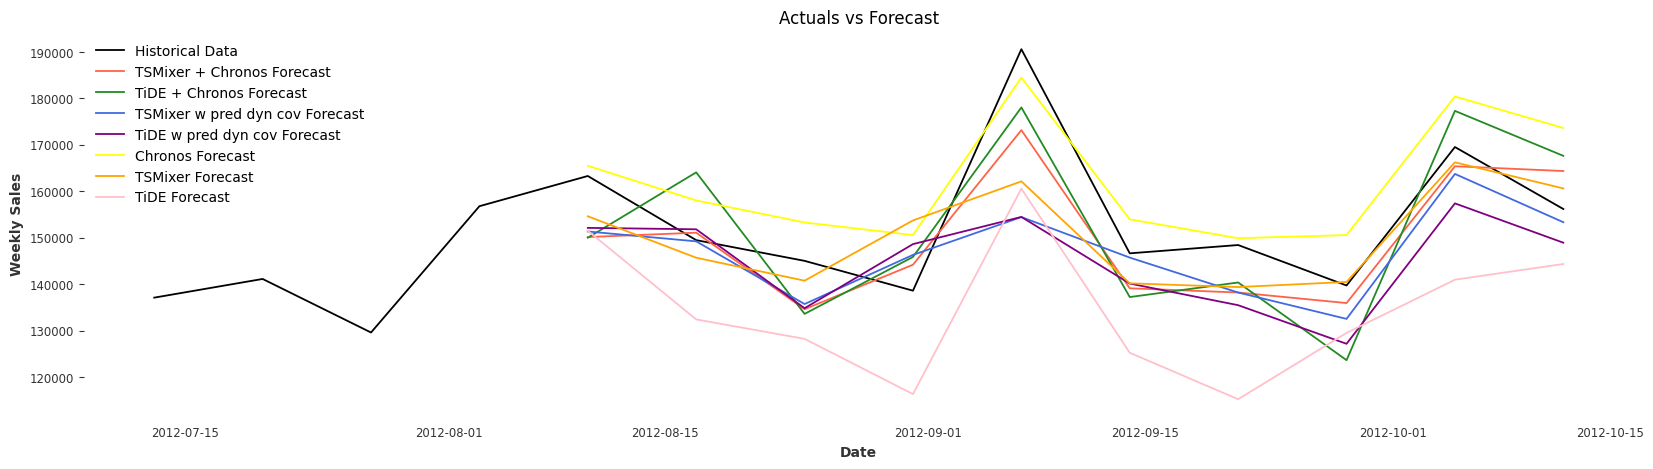

In [17]:
for tide_chronos, tsmixer_chronos, chronos, tsmixer, tide, tsmixer_forecast_w_pred_dyn_cov, tide_forecast_w_pred_dyn_cov, test in zip(
        tide_chronos_forecasts, tsmixer_chronos_forecasts, chronos_forecasts, tsmixer_forecasts, tide_forecasts,
        tsmixer_forecasts_w_pred_dyn_cov, tide_forecasts_w_pred_dyn_cov, tests):
    
    series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)[
    'unique_id'].tolist()
    
    for ts in series[:1]:
        forecasts = [(tsmixer_chronos[tsmixer_chronos["unique_id"] == ts], "TSMixer + Chronos"),
                     (tide_chronos[tide_chronos["unique_id"] == ts], "TiDE + Chronos"),
                     (tsmixer_forecast_w_pred_dyn_cov[tsmixer_forecast_w_pred_dyn_cov["unique_id"] == ts], "TSMixer w pred dyn cov"),
                     (tide_forecast_w_pred_dyn_cov[tide_forecast_w_pred_dyn_cov["unique_id"] == ts], "TiDE w pred dyn cov"),
                     (chronos[chronos["unique_id"] == ts], "Chronos"),
                     (tsmixer[tsmixer["unique_id"] == ts], "TSMixer"),
                     (tide[tide["unique_id"] == ts], "TiDE")]

        utils.plot_multiple_forecasts(actuals_data=test[test["unique_id"] == ts], forecast_data_list=forecasts,
                                      title="Actuals vs Forecast", y_label="Weekly Sales", x_label="Date",
                                      forecast_horizon=FORECAST_HORIZON, interval=False, top3_stores=top3_stores)

## Evaluate forecast

### Without tuning

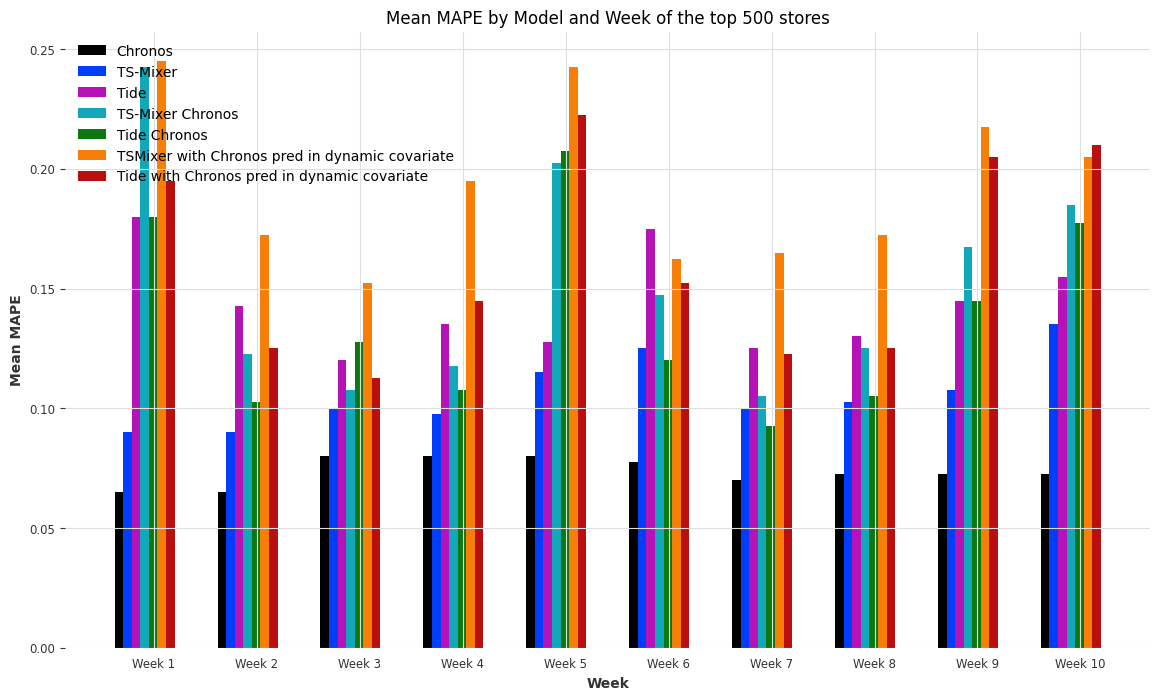

In [19]:
utils.plot_model_comparison([
    chronos_forecasts,
    tsmixer_forecasts,
    tide_forecasts,
    untuned_tsmixer_chronos_forecasts,
    untuned_tide_chronos_forecasts,
    untuned_tsmixer_forecasts_w_pred_dyn_cov,
    untuned_tide_forecasts_w_pred_dyn_cov
], tests)

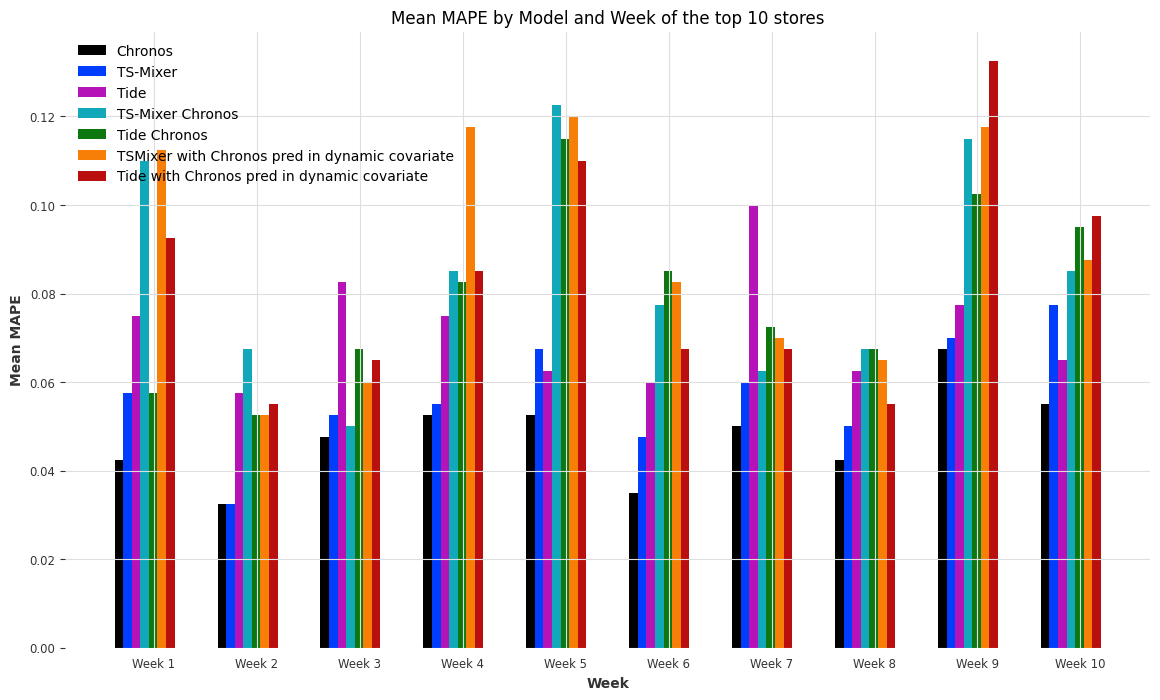

In [20]:
utils.plot_model_comparison([
    chronos_forecasts,
    tsmixer_forecasts,
    tide_forecasts,
    untuned_tsmixer_chronos_forecasts,
    untuned_tide_chronos_forecasts,
    untuned_tsmixer_forecasts_w_pred_dyn_cov,
    untuned_tide_forecasts_w_pred_dyn_cov
], tests, top10_stores=top10_stores)

### With tuning

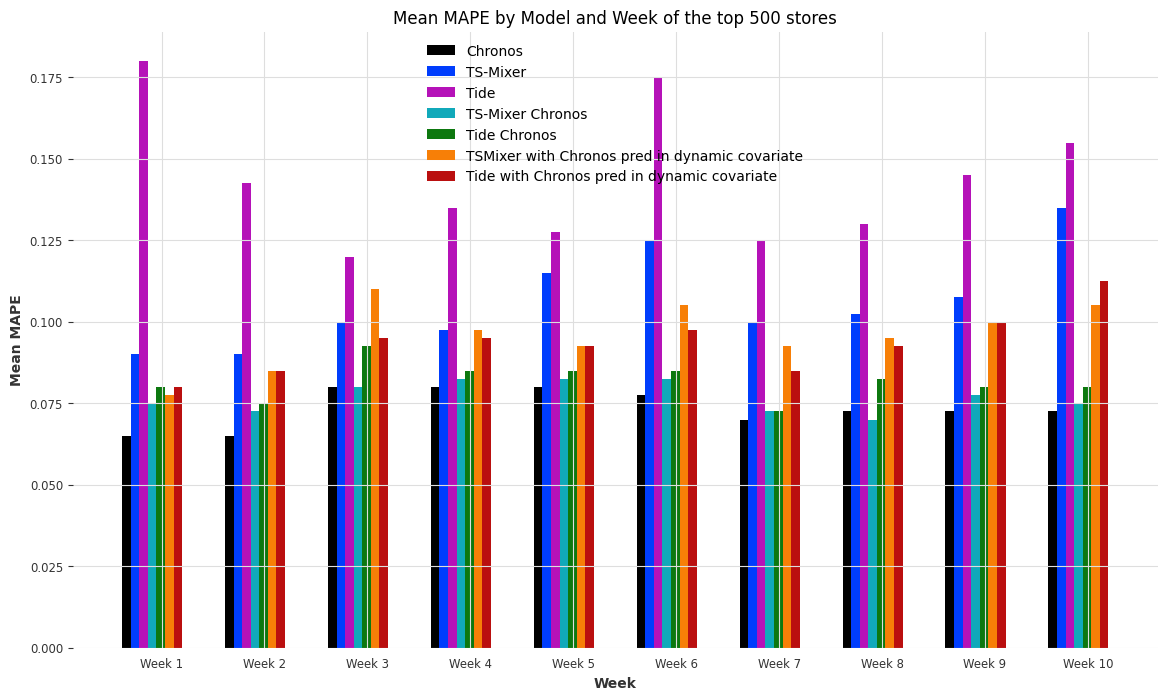

In [21]:
utils.plot_model_comparison([
    chronos_forecasts,
    tsmixer_forecasts,
    tide_forecasts,
    tsmixer_chronos_forecasts,
    tide_chronos_forecasts,
    tsmixer_forecasts_w_pred_dyn_cov,
    tide_forecasts_w_pred_dyn_cov
], tests)

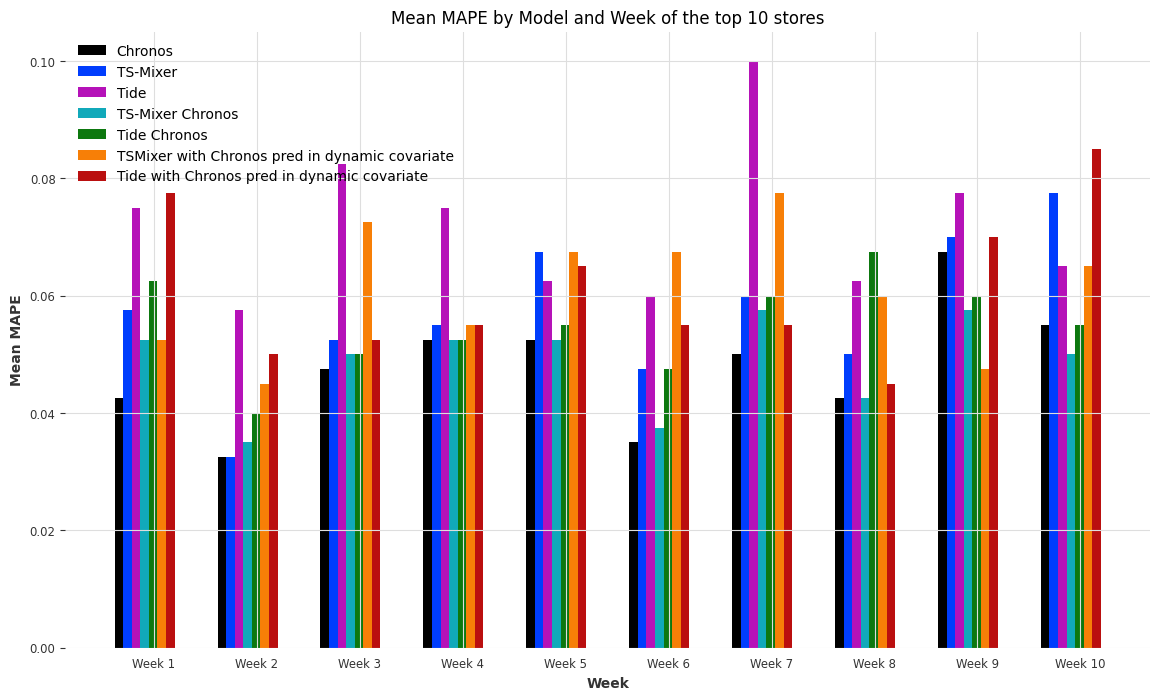

In [22]:
utils.plot_model_comparison([
    chronos_forecasts,
    tsmixer_forecasts,
    tide_forecasts,
    tsmixer_chronos_forecasts,
    tide_chronos_forecasts,
    tsmixer_forecasts_w_pred_dyn_cov,
    tide_forecasts_w_pred_dyn_cov
], tests, top10_stores=top10_stores)